In [9]:
# 데이터 확인
import matplotlib.pyplot as plt # 시각화를 위한 matplotlib 모듈
import glob as gb # 파일들의 리스트를 가져오는 모듈
import pandas as pd
import os
import numpy as np
import tensorflow as tf

from sklearn.utils import shuffle

# from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
# from tensorflow.python.keras.optimizers import RMSprop
# from tensorflow.python.keras.testing_utils import ImageDataGenerator
# from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
path_test  = "test/test"
path_train = "train/train"

In [11]:
s = [] # 빈 리스트 생성

train_files = gb.glob(pathname= str( path_train + '/*.jpg')) # 해당 폴더 안의 jpg로 끝나는 파일 찾기
for file in train_files:
    image = plt.imread(file) # 파일 리스트 하나하나에 해당하는 이미지를 가져와서 shape을 저장 
    s.append(image.shape)

# 파일들 마다 shape 어떤 구성을 가졌는지 파악
pd.Series(s).value_counts()

(374, 500, 3)    2955
(375, 499, 3)    2912
(499, 375, 3)     261
(333, 499, 3)     229
(500, 374, 3)     227
                 ... 
(346, 336, 3)       1
(47, 60, 3)         1
(181, 245, 3)       1
(164, 215, 3)       1
(395, 211, 3)       1
Length: 8513, dtype: int64

In [36]:
import cv2

X_train = [] # 이미지 어레이
Y_train = [] # 각 이미지의 정답 (0,1 값) 1: 개, 0: 고양이
X_Title=[] # 


size=180 # 사진의 크기를 맞추어줄 사이즈

for file in train_files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (size,size)) # 180 x 180 으로 이미지를 변환
    X_train.append(list(image_array)) 
    
    file=file.split('\\')[-1] 
    sep=file.split('.')[0]
    X_Title.append(sep)

    # 만약, 파일 이름에 'dog' 를 가졌다면 1, 아니면 0으로 구분
    if(sep=='dog'):
        Y_train.append(1)
    else:
        Y_train.append(0)

In [37]:
X_test = []

test_files = gb.glob(pathname= str( path_test + '/*.jpg'))
for file in test_files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (size,size))
    X_test.append(list(image_array))
    
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)

In [38]:
print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {Y_train.shape}')

print('Size OF Image = ',np.array(X_train[5]).shape)

X_train shape  is (25000, 180, 180, 3)
X_test shape  is (12500, 180, 180, 3)
y_train shape  is (25000,)
Size OF Image =  (180, 180, 3)


In [39]:
X_train, Y_train= shuffle(X_train, Y_train, random_state=True)

Y_train = tf.one_hot(Y_train, 2)

<AxesSubplot:>

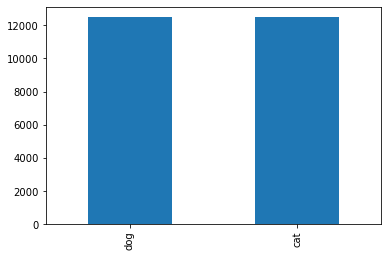

In [40]:
X_Train=X_train[:20000]
Y_Train=Y_train[:20000]
X_val=X_train[20000:]
y_val=Y_train[20000:]

# cat 과 dog 가 같은 비율로 있는 것을 확인
X_Title=np.array(X_Title)
pd.Series(X_Title).value_counts().plot.bar()

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [42]:
Earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            lr=0.0001,
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [Earlystop, learning_rate_reduction]

In [43]:
import keras

In [27]:
model = keras.Sequential([
keras.layers.InputLayer( input_shape=(size, size, 3) ),
# 입력층(입력으로 들어가는 이미지의 사이즈를 지정)

keras.layers.Conv2D(filters=16,kernel_size = (3, 3),strides=1),
keras.layers.Activation(activation='relu'),
keras.layers.MaxPool2D(),
# 합성곱(필터 : 몇 개의 필터를 가지는가?,  커널 사이즈 : 3x3 크기의 커널 사이즈 , 스트라이드 : 얼만큼 움직이는가?) 
# 활성화 함수 ReLu
# 풀링 층

keras.layers.Conv2D(filters=32,kernel_size = (3, 3),strides=1),
keras.layers.Activation(activation='relu'),
keras.layers.MaxPool2D(),    
keras.layers.BatchNormalization(),
    
keras.layers.Dense(32,activation='relu') ,
keras.layers.Dense(16,activation='relu') ,
keras.layers.Flatten(),

# 전연결층으로 이어줌

keras.layers.Dense(units=2,activation='softmax') ])

# 마지막 계층 2개의 유닛을 softmax 함수에 통과시키면
# 0 : 70% , 1 : 30% 와 같이 나타난 확률에 대해  가장 높은 확률인 0으로 변환되어
# [0, 1]과 같은 예측 값을 도출하고, 정답인 y_train과 비교. 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# 비교 시 손실함수는 이진 분류시 사용되는 categorical_crossentropy가 사용되고, 최적화 과정에서 Rmsprop을 사용. 
model.build()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 activation_2 (Activation)   (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 activation_3 (Activation)   (None, 87, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                  

In [28]:
epochs = 200

ThisModel = model.fit(X_Train, Y_Train, epochs=epochs,batch_size=32,verbose=1,callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/200
625/625 [==============================] - 21s 33ms/step - loss: 0.0017 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
625/625 [==============================] - 20s 31ms/step - loss: 5.9605e-12 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/200
625/625 [==============================] - 19s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/200
625/625 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 [==============================] - 20s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/200
625/625 [==============================] - 20s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch

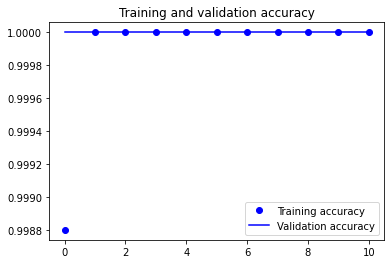

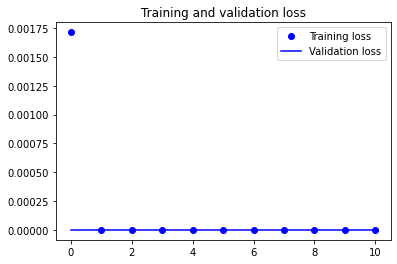

In [29]:
accuracy = ThisModel.history['accuracy']
val_accuracy = ThisModel.history['val_accuracy']
loss = ThisModel.history['loss']
val_loss = ThisModel.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [30]:
y_result = model.predict(X_test)

print('Prediction Shape is {}'.format(y_result.shape))

391/391 [==============================] - 4s 10ms/step
Prediction Shape is (12500, 2)


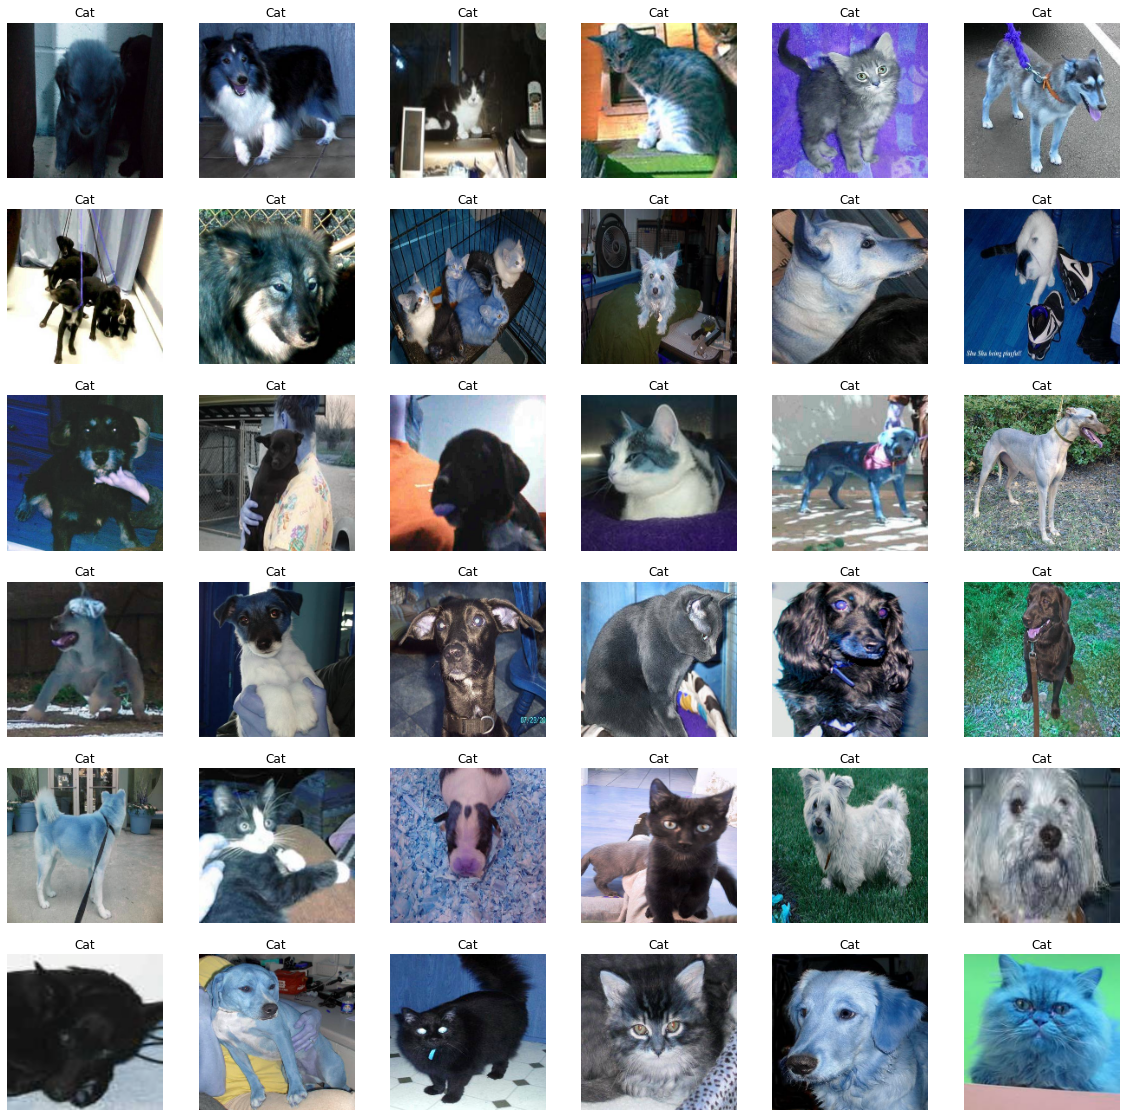

In [32]:
from tensorflow.keras.preprocessing.image import array_to_img

plt.figure(figsize=(20,20))

for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(array_to_img(X_test[i]))     
    plt.axis('off')
    title = ''
    if np.argmax(y_result[i])==1:
        title = 'Dog'
    else:
        title = 'Cat'
    plt.title(title)